In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from os import mkdir
from os.path import join, exists

from scipy.stats import ttest_ind

from constants import N_TARGETS, N_SHADOWS, DEEPSETS_HYPERPARAMS, MLP_HYPERPARAMS

In [5]:
import requests
from getpass import getpass

class Barmecide:
    def __init__(self, token, chat=297134477):
        self.token = token
        self.chat = chat

    def send_message(self, text):
        requests.post(
            'https://api.telegram.org/' + 'bot{}/sendMessage'.format(self.token),
            params=dict(chat_id=self.chat, text=text)
        )

token = getpass('Barmecide token:')
barmecide = Barmecide(token)

ModuleNotFoundError: No module named 'requests'

In [6]:
RESULTS_FOLDER = os.path.join(os.getcwd(), 'results')
FIGURES_FOLDER = os.path.join(os.getcwd(), 'figures')
DATA_FOLDER = os.path.join(os.getcwd(), 'data')

In [4]:
if not exists(RESULTS_FOLDER):
    mkdir(RESULTS_FOLDER)
    
if not exists(FIGURES_FOLDER):
    mkdir(FIGURES_FOLDER)

In [5]:
sns.set_theme(palette=sns.color_palette('YlOrRd_r', 3))
sns.set_context('notebook', font_scale=1.5)

In [6]:
asia = pd.read_csv(join(DATA_FOLDER, 'asia.csv.gz'), index_col=0)
print(asia.shape)
asia.head()

(16384, 8)


,asia,tub,smoke,lung,bronc,either,xray,dysp
0,1,1,0,1,0,1,1,0
1,1,1,1,0,0,0,0,0
2,1,1,0,1,0,1,1,0
3,1,1,1,1,0,1,1,0
4,1,1,0,1,0,1,0,0


In [7]:
asia.dtypes

asia      int64
tub       int64
smoke     int64
lung      int64
bronc     int64
either    int64
xray      int64
dysp      int64
dtype: object

In [8]:
asia.xray.value_counts()

1    14541
0     1843
Name: xray, dtype: int64

In [9]:
asia.dysp.value_counts()

1    9237
0    7147
Name: dysp, dtype: int64

In [10]:
asia.smoke.value_counts()

0    8290
1    8094
Name: smoke, dtype: int64

In [ ]:
%%time

from propinfer.generator import SubsamplingGenerator
from propinfer.experiment import Experiment
from propinfer.model import MLP

from models import IRM

from copy import copy

MLP_HYPERPARAMS['input_size'] = asia.shape[1]
MLP_HYPERPARAMS['n_classes'] = 2

N_RUNS = 10

res = pd.DataFrame(columns=['Dataset', 'Model', 'Proportion', 'Accuracy'])

for prop in np.arange(0.1, 1., 0.1):
    print(f'Running ERM experiment for prop={prop:.1f}')
    gen = SubsamplingGenerator(data=asia, label_col='xray', sensitive_attribute='dysp', proportion=prop, split=True)
    exp = Experiment(generator=gen, label_col='xray', model=MLP, n_targets=N_TARGETS, n_shadows=N_SHADOWS, hyperparams=MLP_HYPERPARAMS, n_queries=2048)
    
    exp.run_targets()
    exp.run_shadows()
    
    acc = exp.run_whitebox_deepsets(DEEPSETS_HYPERPARAMS, n_outputs=N_RUNS)
    
    res.loc[len(res)] = ('Asia', 'ERM', prop, acc)
    
    barmecide.send_message(f'Experiment done: ERM prop={prop} (res={np.mean(acc)})')
    
IRM_HYPERPARAMS = copy(MLP_HYPERPARAMS)    

IRM_HYPERPARAMS['input_size'] = asia.shape[1] - 2
IRM_HYPERPARAMS['epochs'] = 2**11
IRM_HYPERPARAMS['reg'] = 0.1
IRM_HYPERPARAMS['env_label'] = 'smoke'
    
for prop in np.arange(0.1, 1., 0.1):
    print(f'Running IRM experiment for prop={prop:.1f}')
    gen = SubsamplingGenerator(data=asia, label_col='xray', sensitive_attribute='dysp', proportion=prop, split=True)
    exp = Experiment(generator=gen, label_col='xray', model=IRM, n_targets=N_TARGETS, n_shadows=N_SHADOWS, hyperparams=IRM_HYPERPARAMS, n_queries=2048)
    
    exp.run_targets()
    exp.run_shadows()
    
    acc = exp.run_whitebox_deepsets(DEEPSETS_HYPERPARAMS, n_outputs=N_RUNS)
    
    res.loc[len(res)] = ('Asia', 'IRM', prop, acc)
    
    barmecide.send_message(f'Experiment done: IRM prop={prop} (res={np.mean(acc)})')

Running ERM experiment for prop=0.1


In [ ]:
res.explode('Accuracy').to_csv(join(RESULTS_FOLDER, 'real_data.csv'))

In [15]:
res = pd.read_csv(join(RESULTS_FOLDER, 'real_data.csv'), index_col=0)
res

,Dataset,Model,Proportion,Accuracy
0,Asia,ERM,0.1,0.683594
0,Asia,ERM,0.1,0.753906
0,Asia,ERM,0.1,0.688477
0,Asia,ERM,0.1,0.647461
0,Asia,ERM,0.1,0.708984
...,...,...,...,...
17,Asia,IRM,0.9,0.500977
17,Asia,IRM,0.9,0.503906
17,Asia,IRM,0.9,0.483398
17,Asia,IRM,0.9,0.468750


<AxesSubplot:xlabel='Proportion', ylabel='Accuracy'>

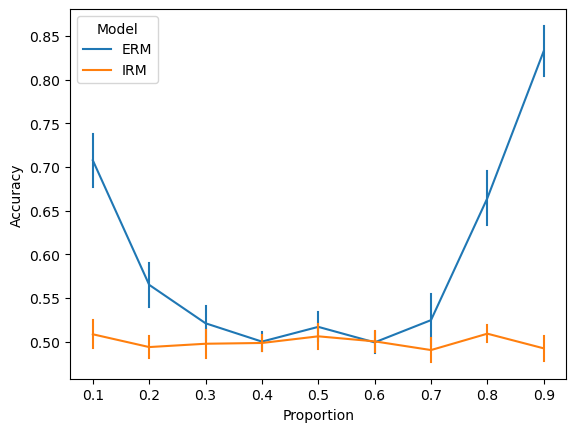

In [16]:
sns.lineplot(data=res, x='Proportion', y='Accuracy', hue='Model', errorbar='sd', err_style='bars')